# Traffic Sign Detection and Classification

We will start with an already trained ResNet arquitecture using [fastai](https://github.com/fastai/fastai). This step will only use the largest area sign on the picture as there are pictures with more than one sign.

In [1]:
from xml.dom import minidom
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = []
test = []

with open("test.txt") as _file:
    for line in _file:
        train.append(line.replace('\n', ''))

with open("train.txt") as _file:
    for line in _file:
        test.append(line.replace('\n', ''))

def create_dataframe(data):
    signs = []
    for name in data:
        file = minidom.parse("annotations/" + name + ".xml")
        path = "images/" + file.getElementsByTagName('filename')[0].firstChild.data
        filename = file.getElementsByTagName('filename')[0].firstChild.data
        
        objects = file.getElementsByTagName('object')
        
        current_max = {"area": 0, "name": None}
        
        for obj in objects:
            xmin = obj.getElementsByTagName("xmin")[0].firstChild.data
            xmax = obj.getElementsByTagName("xmax")[0].firstChild.data
            ymin = obj.getElementsByTagName("ymin")[0].firstChild.data
            ymax = obj.getElementsByTagName("ymax")[0].firstChild.data
            
            name = obj.getElementsByTagName("name")[0].firstChild.data
            area = abs(int(xmax)-int(xmin))*abs(int(ymax)-int(ymin))
            if current_max["area"] < area:
                current_max = {"area": area, "name": name}

        signs.append([filename, current_max["name"], path])

    return pd.DataFrame(signs, columns=['filename', 'tag', 'path'])

df_train = create_dataframe(train)
df_test = create_dataframe(test)

## Fine Tuning ResNet50

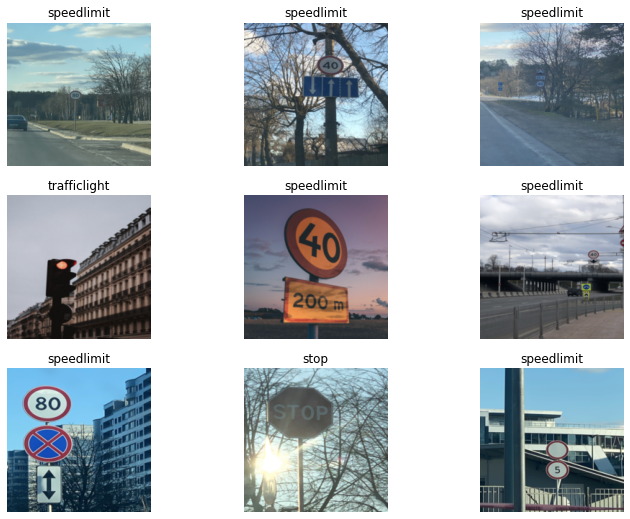

In [3]:
from fastai.vision.all import *

bs = 32
batch_tfms = aug_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)
item_tfms = [ Resize((200, 200), method='squish')]

datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref='images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1),
                   item_tfms = item_tfms)

dls_train = datablock.dataloaders(df_train, bs=bs)
dls_test = dls_train.test_dl(df_test, with_labels=True, bs=bs)

dls_train.show_batch(max_n=9, figsize=(12,9))

Find a good learning rate to start with

SuggestedLRs(valley=0.0008317637839354575)

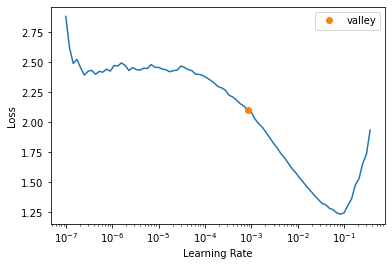

In [4]:
learn = vision_learner(dls_train, resnet50, pretrained=True, metrics=[accuracy])

learn.lr_find()

Use the suggested learning rate to fit on cycle

In [5]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.202077,1.745335,0.326923,00:02
1,1.743794,0.870872,0.634615,00:01
2,1.380269,0.844646,0.673077,00:01
3,1.114727,0.882755,0.692308,00:01
4,1.001546,0.904157,0.711538,00:01


Find another good learning rate to continue

In [6]:
learn.save('tr-single-stage-1')

Path('models/tr-single-stage-1.pth')

SuggestedLRs(valley=0.00015848931798245758)

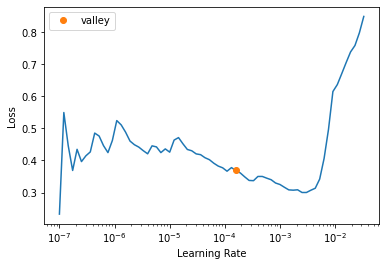

In [7]:
learn.unfreeze()
learn.lr_find()

In [8]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.453188,0.901708,0.692308,00:02
1,0.433724,0.836020,0.730769,00:02
2,0.384614,0.705451,0.750000,00:02
3,0.351447,0.668911,0.788462,00:02
4,0.304588,0.651532,0.788462,00:02


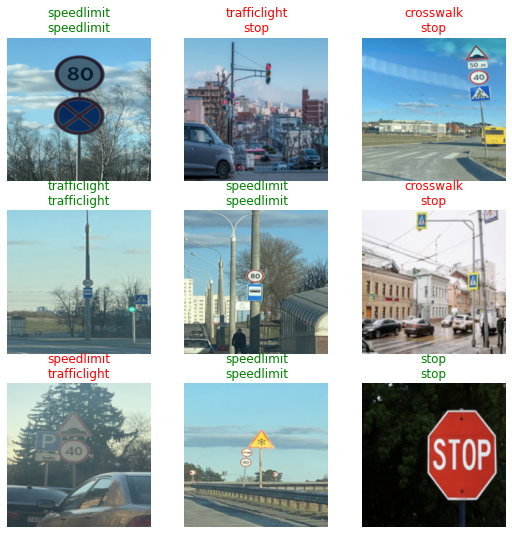

In [9]:
learn.show_results()

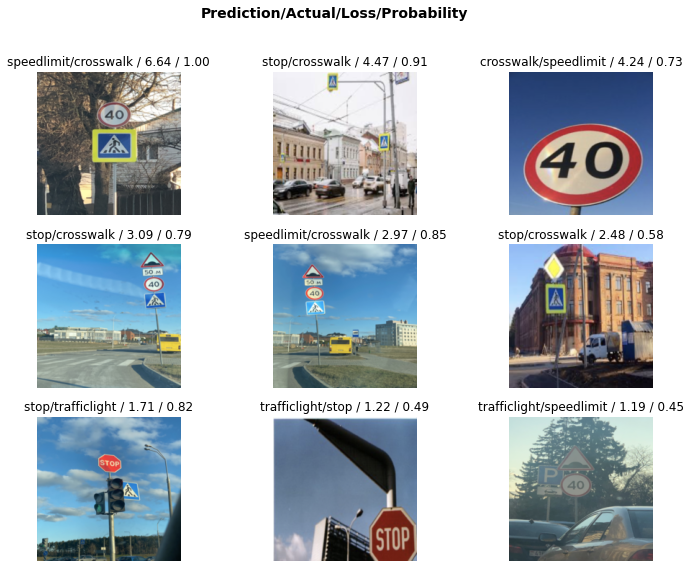

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,9));

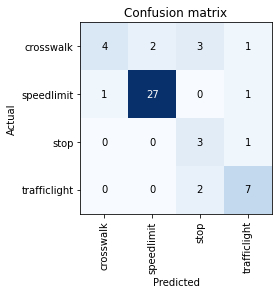

In [11]:
interp.plot_confusion_matrix()

In [12]:
loss, acc = learn.validate(dl=dls_test)

print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 1.2822985649108887, Accuracy: 55.9543251991272 %
